In [1]:
import numpy as np
from meshtools import *
import NeuralField as nf
import ConnectivityKernel as ck
import FiringRate as fr
import QuadratureInTriangles as Qtri
import InitialConditions as ic
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.mlab import griddata
%matplotlib inline

In [2]:
# Used for Plotting 3D result with linear vectors
def toMeshGrid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib meshgrid"
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi)
    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

In [3]:
# Generate Mesh
Lx=-30; Ux=30
Ly=-30; Uy=30
length = 3 # Decrease length to increase number of elements
p,v=RectangleSegments([Ux,Uy],[Lx, Ly],edge_length=length)
mesh_pts, elems = DoTriMesh(p,v,edge_length=length)
NT = len(elems) # Number of triangles
print("Number of Elements = " + str(NT))

Number of Elements = 1234


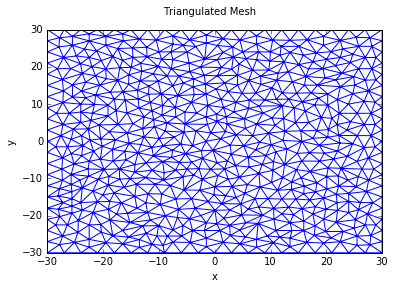

In [4]:
# plot mesh
plot_mesh = True
if(plot_mesh):
    fig1 = plt.figure()
    fig1.suptitle("Triangulated Mesh")
    ax = fig1.add_subplot(111)
    ax.triplot(mesh_pts[:, 0], mesh_pts[:, 1], elems)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig1.savefig("The Mesh")

In [5]:
Np = 2 # Desired number of gauss points.

gwp = Qtri.getWeightsAndPoints(Np)

x_hat = gwp[:,0]
y_hat = gwp[:,1]
weights = gwp[:,2]

print("x_hat = "+str(x_hat))
print("y_hat = "+str(y_hat))
print("wgts = "+str(weights))

Ng = len(weights) # Actual Number of Gauss points.

x_hat = [ 0.16666667  0.16666667  0.66666667]
y_hat = [ 0.16666667  0.66666667  0.16666667]
wgts = [ 0.33333333  0.33333333  0.33333333]


In [6]:
# Assemble Mesh of Interior Points
xs = []
As = []
for l, elem in enumerate(elems):
    v1,v2,v3 = mesh_pts[elem] # Get vertices of the element
    A_l = Qtri.computeArea(v1,v2,v3)
    As.append(A_l)
    for j in range(len(weights)):
        new_point = Qtri.mapX(v1, v2, v3, x_hat[j], y_hat[j])
        xs.append(new_point)
xs = np.array(xs)
As = np.array(As)
N = len(xs)

In [7]:
# Visualize interior points
visualize = False # Change flag if you want to visualize the mesh with interior points
if(visualize):
    fig2 = plt.figure(figsize = (9,6))
    fig2.suptitle("Triangulated Mesh with " +str(Ng)+" Interior Gauss Points")
    ax = fig2.add_subplot(111)
    ax.triplot(mesh_pts[:, 0], mesh_pts[:, 1], elems)
    for p in xs:
        ax.plot([p[0]],[p[1]], 'r.')
    ax.set_xlabel("x")
    ax.set_xlabel("y")
    fig2.savefig("Mesh With "+str(Ng)+" Interior Points")

In [8]:
# Initialize Connectivity Kernel
b = 0.4
kernel = ck.ConnectivityKernel2(b)

In [9]:
# Assemble Synaptic Matrix
wts_o = np.outer(As.T, weights)
rhos = wts_o.flatten()

W = np.zeros((N,N))
for i in range(0, N):
    x_pt = xs[i]
    for j in range(i, N):
        y_pt = xs[j]
        x, y = x_pt-y_pt
        W[i,j] = kernel(x, y) 
        
# Copy upper triangular part to lower triangular part
i_lower = np.tril_indices(N, -1)
W[i_lower] = W.T[i_lower]

# Multiply times the weights
W *= rhos
del rhos # delete to free memory

In [10]:
# Parameters for Firing Rate
mu = 3.2; theta = 5.6;
f_rate = fr.FiringRate2(mu, theta)

# Initialize Neural Field
NeuralField = nf.NeuralField(f_rate, W)

In [11]:
# Initial Conditions
#_A = 6; _L = 5.77 # parameters for initial condition 1
_A = 2; _L = 100 # parameters for initial condition 2
initCond = ic.InitialCondition2(_A, _L)

u0 = []
for point in xs:
    x,y = point
    u0.append(initCond(x,y))
u0 = np.array(u0)

In [12]:
method = ode(NeuralField).set_integrator("dopri5")
method.set_initial_value(u0)
final_t = 15
dt = 0.1
us = []
time_points = []
while method.t < final_t:
    next_t = method.t+dt
    time_points.append(next_t)
    next_u = method.integrate(next_t)
    us.append(next_u)

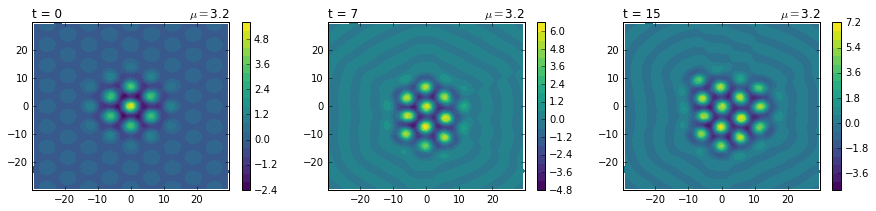

In [13]:
fig = plt.figure(figsize=(15,3))

# Plot initial time
ax1 = fig.add_subplot(131)
xx0, yy0, uu0 = toMeshGrid(xs[:,0], xs[:,1], u0)
cont1 = ax1.contourf(xx0, yy0, uu0, 20, cmap=plt.get_cmap('viridis'))
ax1.set_title("t = 0", loc="left")
ax1.set_title(r'$\mu =$'+str(mu), loc="right")
plt.colorbar(cont1)

# Plot half time
ax2 = fig.add_subplot(132)
xn_2, yn_2, un_2 = toMeshGrid(xs[:,0], xs[:,1], us[int(len(time_points)/2)])
cont2 = ax2.contourf(xn_2, yn_2, un_2, 20, cmap=plt.get_cmap('viridis'))
ax2.set_title("t = "+str(int(final_t/2)), loc="left")
ax2.set_title(r'$\mu =$'+str(mu), loc="right")
plt.colorbar(cont2)

# Plot final time
ax3 = fig.add_subplot(133)
xn, yn, un = toMeshGrid(xs[:,0], xs[:,1], us[-1])
cont3 = ax3.contourf(xn, yn, un, 20, cmap=plt.get_cmap('viridis'))
ax3.set_title("t = "+str(final_t), loc="left")
ax3.set_title(r'$\mu =$'+str(mu), loc="right")
plt.colorbar(cont3)
plt.savefig("Plots/IC"+str(initCond.num)+"/2dTri_IC"+str(initCond.num)+str(NT)+"_elems_("+str(mu)+")mu.png")